<a href="https://colab.research.google.com/github/samkio/MachineLearningProjects/blob/main/MaterialIdentifierV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 1.2MB 30.2MB/s 
     |████████████████████████████████| 194kB 42.3MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 12.8MB 238kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Identifying Materials of Waste Products


This notebook extends on the learning of https://github.com/fastai/fastbook/blob/master/02_production.ipynb where we will be investigating if we can detect what type of material a waste product is made from. For example can we destinquish between tin, glass, paper, cardboard and plastic? The hope is to be able to aid people in understanding what they can recycle by taking a photo of the product.


# Data Gathering

We will be utilizing the Bing Images API to obtain images for each material such that we can train our model on.

For this we will need to hook into [Bing Images API](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) and obtain a key. This can be set below.

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

Let's get a feel for what images we will be obtaining.

In [ ]:
results = search_images_bing(key, 'tin can')
ims = results.attrgot('contentUrl')
len(ims)

150

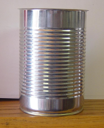

In [ ]:
Path('./images/').mkdir()
dest = Path('./images/tin_can.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

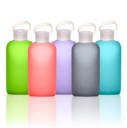

In [ ]:
results = search_images_bing(key, 'glass bottle')
ims = results.attrgot('contentUrl')
dest = Path('./images/glass_bottle.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

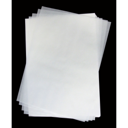

In [ ]:
results = search_images_bing(key, 'paper')
ims = results.attrgot('contentUrl')
dest = Path('./images/paper.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

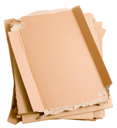

In [ ]:
results = search_images_bing(key, 'cardboard')
ims = results.attrgot('contentUrl')
dest = Path('./images/cardboard.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

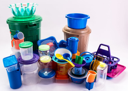

In [ ]:
results = search_images_bing(key, 'plastic product')
ims = results.attrgot('contentUrl')
dest = Path('./images/plastic_product.jpg')
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

As we can see from these examples the images we get from Bing are unrealistic representations of products. They show the materials in their pure forms with very little noise around them. If we hope to be able to distinguish from user photos further real-world photos with noise will be required. For this experiment however we will take this assumption into account and will proceed knowing that the images may not fully represent real-world photos.

In [5]:
material_types = {'tin':"tin can",'glass': "glass bottle",'paper': "paper",'cardboard': "cardboard",'plastic': "plastic product"}
path = Path('materials')

In [6]:
if not path.exists():
    path.mkdir()
    for o, term in material_types.items():
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, term)
        download_images(dest, urls=results.attrgot('contentUrl'))

This code below verifies that the images are not corrupted and can be used to train our model.

In [9]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);

# Loading the Data

We are now going to load the images we obtained into a DataLoader object. This encapsulates the data we will be using to train and test our model; it will have the "train" and "validation" datasets. It also provides data on how we label the images.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


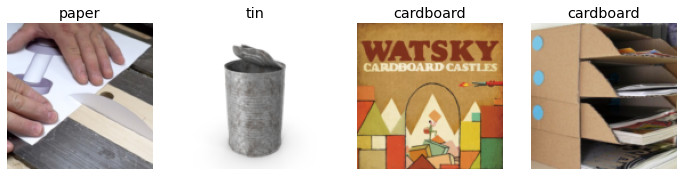

In [10]:
materials = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = materials.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Here we load the data using 20% of the data for our validation dataset and the remaining 80% as our training dataset. We can see some examples by showing a batch.

We will be using Data Augmentation to further extend our dataset. These augmentations will include rotations, flipping, perspective warping, brightness changes and contrast changes. This was done as the fundamental subject of the image will not change when these augmentations are done to the image. Doing this improves the accuracy of the model by providing more data and will be more useful in the real world as it is very rare that a photo be taken in the exact same way.

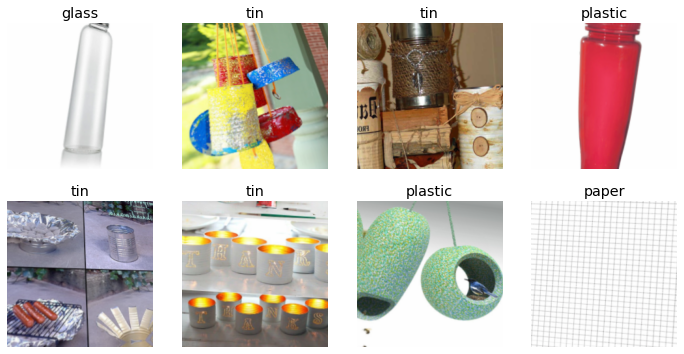

In [16]:
materials = materials.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = materials.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

# Modelling

We now use the learner to fine tune a model for our experiment.

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.288444,1.357895,0.401460,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.918959,0.910548,0.306569,00:21
1,0.765473,0.852208,0.255474,00:21
2,0.608235,0.866395,0.218978,00:20
3,0.509148,0.885242,0.248175,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Using the confusion matrix we can see what areas are causing confusion for the model. We can also see what images are causing the to be the most problematic for the model.

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


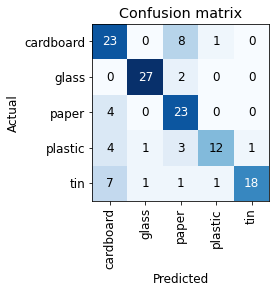

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

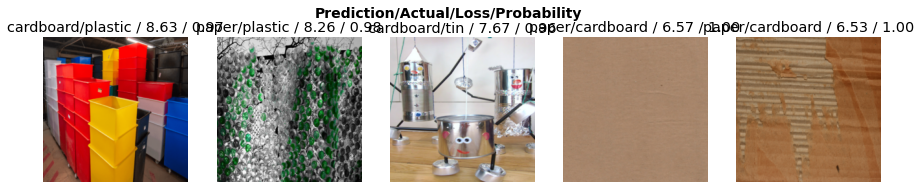

In [19]:
interp.plot_top_losses(5, nrows=1)

From the confusion matrix we see that the model appears to be performing fairly well at identifiying materials correctly. Glass appears to be the easiest to classify with only 2 occurances being mis-predicted as paper.

The largest areas of confusion is cardboard being mis-predicted as paper and tin being mis-predicted as cardboard.

Looking at the top losses we see that some of the images are not representative of photos that a user would take to try and identify a product. Before we re-think which keywords will better capture our target photo types let's try cleaning up the data we have already. 

In [41]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [35]:
#hide
for idx in cleaner.delete(): 
  try:
    cleaner.fns[idx].unlink()
  except:
    print("An exception occurred")
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

When cleaning the images we see a lot of images that are very unrelated. For example the paper material type has wallpaper and many papercraft photos. 

Similarly tin has tin crafts and infographic like images which contain multiple images within them.

Having cleaned these from the dataset we assess to see if this has improved the accuracy of our model. One thing is clear however that having images that better represent what we wish to be able to differentiate in the setting that is intended is paramount for the model to be effective.

What is promising however is that the image net used shows promise in being able to differentiate between material types. Further research must be done however to see if this is maintained with more representative photos.

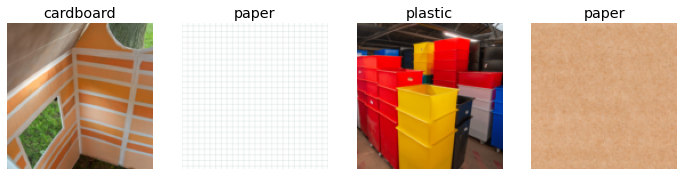

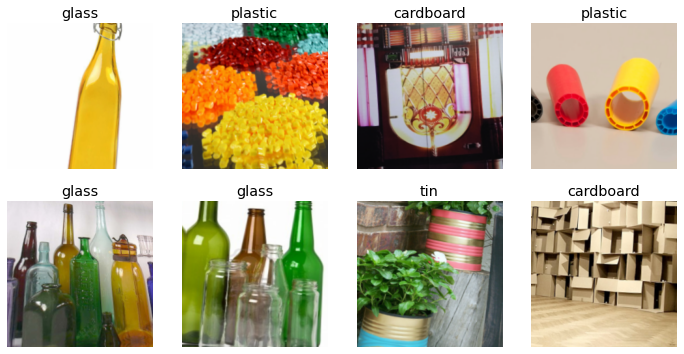

In [37]:
materials = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = materials.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)
materials = materials.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = materials.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

In [38]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.975598,1.162838,0.225564,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.833338,0.675788,0.187970,00:20
1,0.675519,0.611035,0.210526,00:20
2,0.565295,0.611374,0.180451,00:20
3,0.477013,0.598673,0.187970,00:20


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


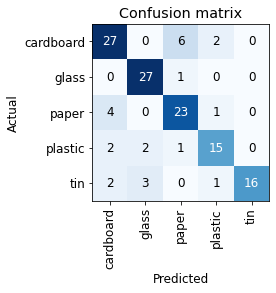

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

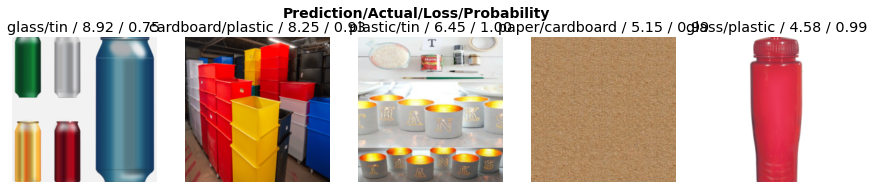

In [40]:
interp.plot_top_losses(5, nrows=1)

There is some marginal improvement by cleaning up the data but the algorithm still mis-classifies some products. For example paper instead of cardboard and some plastic bottles that look like glass bottles.

# Conclusion

We can see that the model is able to classify many materials with an approximate 80% accuracy. It is clear that the model is able to pick up the key identifiers for materials but still miss-classifys some products.

For my next test I wish to obtain a better dataset that is more representative of photos users would take of products they wish to classify.

I see a few ways to achieve this:
1. Collect real world photos of users. This can be done by setting up a site that attempts to classify that over-time collects more data such that it is able to better identify future products.
2. Carefully curate the image list. For example rather than searching for "tin can" the bing image search could search for "heinz bean can" or "fizzy drinks can". This will include a label and better represent products that people would take photos of. 
3. Additionally many of the images have white backgrounds in the datasets obtained above. As we expect users to take photos in kitchens/households we can augment images with white backgrounds to have kitchen / household and floors behind them. 

In summary the model shows promise but there are key improvements to be made such that this is an effective model to be used in production.

One thing is clear is that having a clean and clear dataset on what needs to be modelled is paramount to having an effective model.